In [21]:
## first softmax version
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
# Cell 1: Import the module
from gp_softmax_torch_2 import *
## first softmax version
%load_ext autoreload
%autoreload 2
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Generate synthetic data
N, D, T, K, P = 100, 5, 50, 3, 5
Y_np, G_np, prevalence_np, length_scales_np, amplitudes_np, event_times_np = generate_synthetic_data(
    N=N, D=D, T=T, K=K, P=P
)

# Initialize model with Y included
model = AladynSurvivalModel(
    N=N, D=D, T=T, K=K, P=P,
    G=G_np,
    Y=Y_np,  # Pass Y to the model
    length_scales=length_scales_np,
    amplitudes=amplitudes_np,
    prevalence=prevalence_np
)

# Convert event times to tensor
event_times = torch.tensor(event_times_np, dtype=torch.long)

# Setup optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

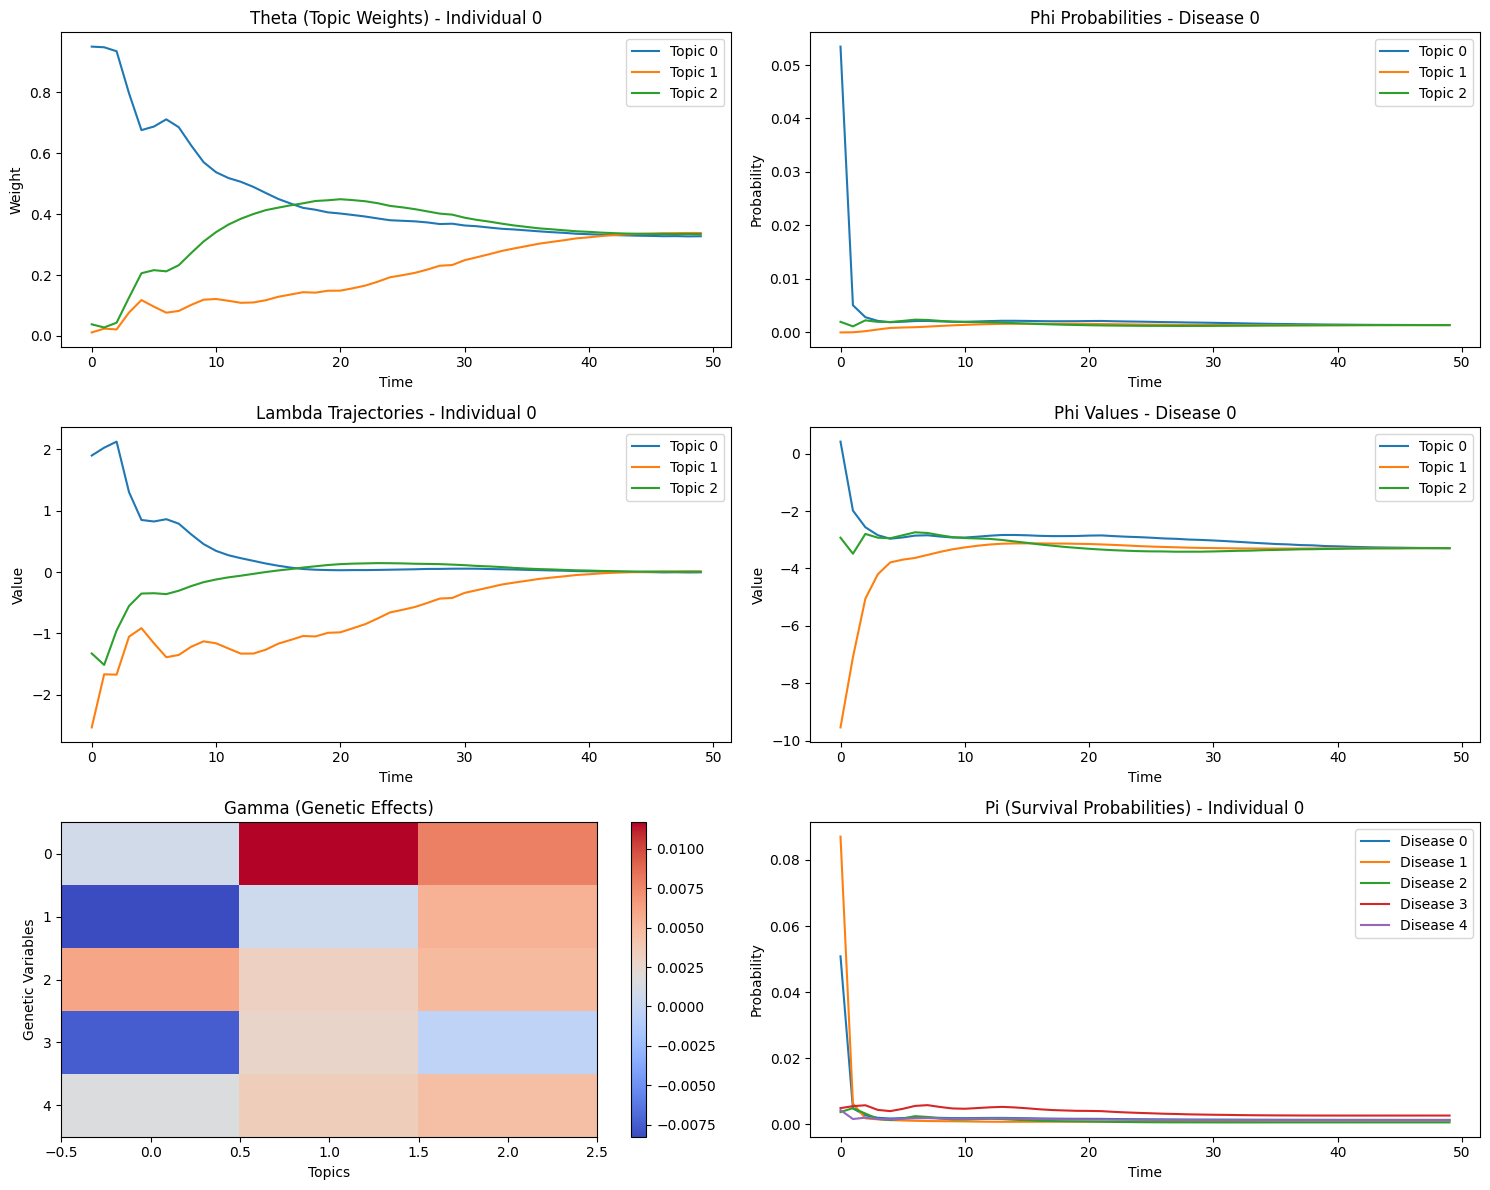

In [23]:
# Get model outputs
pi, theta, phi_prob = model.forward()

# Create visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Survival Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

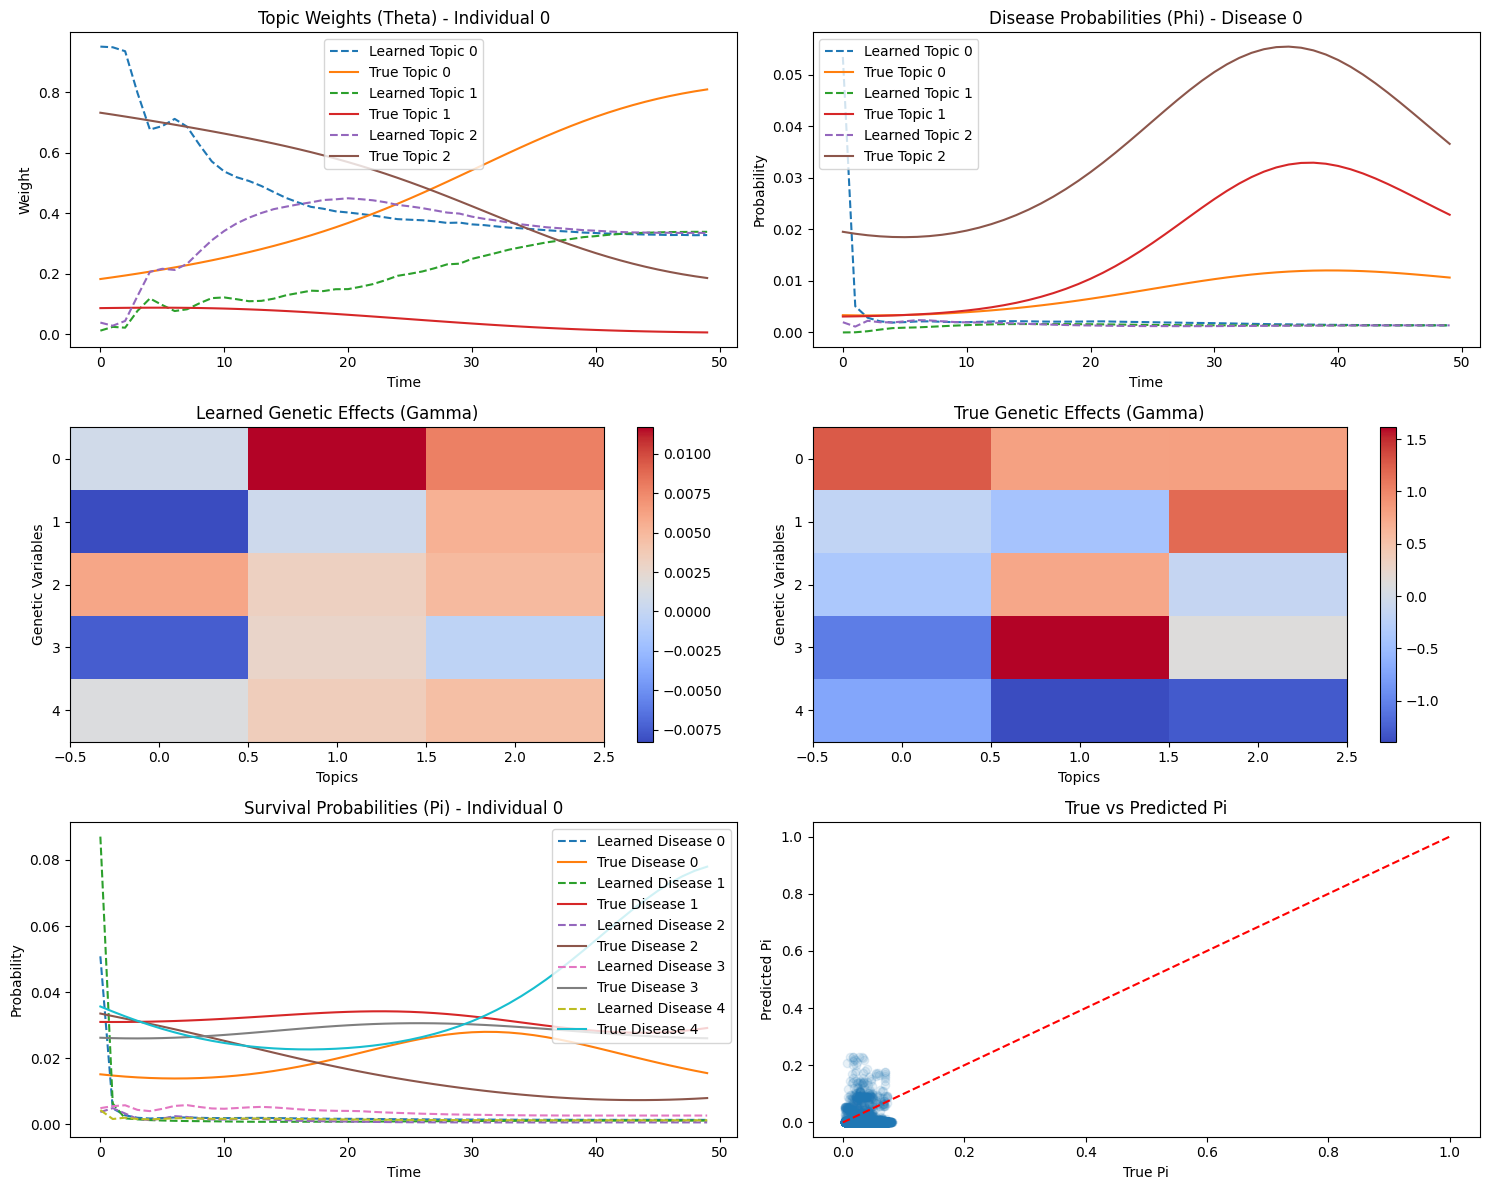


Numerical Metrics:
R² score for Pi: -3.170
MSE for Pi: 0.000859
R² score for Theta: -0.315
R² score for Gamma: -0.001


In [24]:
# Get model predictions and true parameters
pi, theta, phi_prob = model.forward()

# Get true parameters from data generation
true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)

# Create evaluation plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Topic Weights (Theta)
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], '--', label=f'Learned Topic {k}')
    axes[0, 0].plot(true_data['theta'][0, k, :], '-', label=f'True Topic {k}')
axes[0, 0].set_title('Topic Weights (Theta) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Disease Probabilities (Phi)
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], '--', label=f'Learned Topic {k}')
    axes[0, 1].plot(expit(true_data['phi'][k, 0, :]), '-', label=f'True Topic {k}')
axes[0, 1].set_title('Disease Probabilities (Phi) - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Genetic Effects (Gamma)
gamma_np = model.gamma.detach().numpy()
im = axes[1, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
plt.colorbar(im, ax=axes[1, 0])
axes[1, 0].set_title('Learned Genetic Effects (Gamma)')
axes[1, 0].set_xlabel('Topics')
axes[1, 0].set_ylabel('Genetic Variables')

im = axes[1, 1].imshow(true_data['gamma'], aspect='auto', cmap='coolwarm')
plt.colorbar(im, ax=axes[1, 1])
axes[1, 1].set_title('True Genetic Effects (Gamma)')
axes[1, 1].set_xlabel('Topics')
axes[1, 1].set_ylabel('Genetic Variables')

# 4. Final Survival Probabilities (Pi)
pi_np = pi.detach().numpy()
for d in range(D):
    axes[2, 0].plot(pi_np[0, d, :], '--', label=f'Learned Disease {d}')
    axes[2, 0].plot(true_data['pi'][0, d, :], '-', label=f'True Disease {d}')
axes[2, 0].set_title('Survival Probabilities (Pi) - Individual 0')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Probability')
axes[2, 0].legend()

# 5. True vs Predicted Pi
axes[2, 1].scatter(true_data['pi'].flatten(), pi_np.flatten(), alpha=0.1)
axes[2, 1].plot([0, 1], [0, 1], 'r--')
axes[2, 1].set_title('True vs Predicted Pi')
axes[2, 1].set_xlabel('True Pi')
axes[2, 1].set_ylabel('Predicted Pi')

plt.tight_layout()
plt.show()

# Print numerical metrics
from sklearn.metrics import r2_score, mean_squared_error
print("\nNumerical Metrics:")
print(f"R² score for Pi: {r2_score(true_data['pi'].flatten(), pi_np.flatten()):.3f}")
print(f"MSE for Pi: {mean_squared_error(true_data['pi'].flatten(), pi_np.flatten()):.6f}")
print(f"R² score for Theta: {r2_score(true_data['theta'].flatten(), theta_np.flatten()):.3f}")
print(f"R² score for Gamma: {r2_score(true_data['gamma'].flatten(), gamma_np.flatten()):.3f}")